In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
import scipy.optimize as optimize
import scipy.constants

Λ_cutoff = 5000
Nc = 3
mσ = 500
mq = 300
mπ = 1e-5#140
fπ = 93
n_sat = 0.15 #in units fm^-3

MeV = 1e6 * 1.6e-19
ħ = scipy.constants.hbar
c = scipy.constants.c
fm = 1e-15 

ϕ_lin = np.linspace(1e-5, 300, 2)
Δ_lin = np.linspace(0, 400, 10)

In [2]:
def C(p):
    return np.real(2-2*np.emath.sqrt(4*mq**2/(p**2)-1)*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1))))

def dC(p):
    return np.real(4*mq**2/(p**4*np.emath.sqrt(4*mq**2/(p**2)-1))*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1)))-1/(p**2))


def E(p, m):
    return np.sqrt(p**2 + m**2)

def EΔp(p, m, Δ, μ_bar):  
    return np.sqrt((E(p, m) + μ_bar)**2 + Δ**2)

def EΔm(p, m, Δ, μ):
    if Δ == 0:
        return E(p,m)-μ
    else:
        return np.sqrt((E(p, m)-μ)**2 + Δ**2)

def step(x):
    if x >= 0:
        return 1
    else:
        return 0

def Ω_num(ϕ, Δ, μ):
    def integrand(p):
        if Δ == 0:
            return 0
        else:
            return p**2*(EΔp(p, ϕ, Δ, μ) + EΔm(p, ϕ, Δ, μ) - 2*np.sqrt(p**2+ϕ**2+Δ**2) - 2*Δ**2*μ**2/(2*(p**2+ϕ**2+Δ**2)**(3/2))
                    )

    integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 100)

    return 2*integral/(np.pi**2)

In [3]:
def test_func(μ):
    return 2*μ**4/(6*np.pi**2)

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\3475500222.py:34: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 100)
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\3475500222.py:34: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 100)


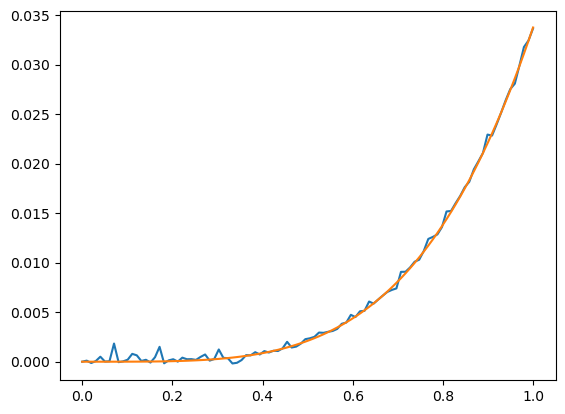

In [4]:
μ_lin = np.linspace(0, 1, 100)
Ω_num_list = [Ω_num(1e-5, 100, μi) for μi in μ_lin]
plt.plot(μ_lin, Ω_num_list)
plt.plot(μ_lin, test_func(μ_lin))

In [5]:
Cσ = C(mσ)
Cπ = C(mπ)
dCπ = dC(mπ)

m0 = np.sqrt(np.abs(3/2*mπ**2*(1 - 4*Nc*mq**2/((4*np.pi)**2*fπ**2)*mπ**2*dCπ) - mσ**2/2*(
        1 + 4*Nc*mq**2/((4*np.pi)**2*fπ**2)*(
        (1-4*mq**2/(mσ**2))*Cσ - Cπ - mπ**2*dCπ + 4*mq**2/(mσ**2)))
                   )
            )
#print(m0)

m0 = np.sqrt((mσ**2-3*mπ**2)/2 + 2*Nc*mq**2/((4*np.pi)**2*fπ**2)*(4*mq**2 + (mσ**2-4*mq**2)*Cσ - mσ**2*Cπ - (mσ**2-3*mπ**2)*mπ**2*dCπ))

#λ0 = (mσ**2*fπ**2/8*(
#        1 + 4*Nc*mq**2/((4*np.pi)**2*fπ**2)*(
#        (1-4*mq**2/(mσ**2))*Cσ - Cπ - mπ**2*dCπ)) 
#      - mπ**2*fπ**2/8*(
#        1 - 4*Nc*mq**2/((4*np.pi)**2*fπ**2)*mπ**2*dCπ))/fπ**4*24

λ0 = 3*(mσ**2-mπ**2)/fπ**2 + 12*Nc*mq**2/((4*np.pi)**2*fπ**4)*((mσ**2-4*mq**2)*(Cσ - Cπ - mπ**2*dCπ) + mπ**4*dCπ)

h0 = -mπ**2*fπ**2*(1-4*Nc*mq**2/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)/fπ

g0 = mq/fπ
λ3 = 0
λΔ=0
mΔ=0
gΔ=1

print(abs(h0)**(1/3),g0, m0, λ0)

0.0021029437174614213 3.225806451612903 487.02239546047457 65.80379080308276


In [6]:
def Ω_vac(ϕ, Δ, μ):
    def Ωϕ(ϕ):
        return  h0*fπ*ϕ/mq - 1/2*m0**2*fπ**2*ϕ**2/(mq**2) + 1/24*λ0*fπ**4*ϕ**4/(mq**4) + 2*mq**4/((4*np.pi)**2)*(np.log(mq**2/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4) + 2*Nc*mq**4/((4*np.pi)**2)*(3/2)*ϕ**4/(mq**4)

    def ΩϕΔ(ϕ, Δ, μ, μe, μ8):
        μ_bar = μ - μe/6 + μ8/3 
        return 1/12*λ3*fπ**2/(gΔ**2*mq**2)*Δ**2*ϕ**2 + 12/((4*np.pi)**2)*ϕ**2*Δ**2 + (mΔ**2-4*μ_bar**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ+mπ**2*dCπ))*μ_bar**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*(Δ**4) +  8/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*Δ**2*ϕ**2 + 4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2+Δ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)
    return Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ, 0, 0)

def Ωμ_original(ϕ, Δ, μ):
    if Δ == 0:
        def integrand(p):
            return p**2*(μ-E(p, ϕ))
            
        integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
        return -4*Nc*integral/(2*np.pi**2)
        
    else:
        def integrand(p):
            return p**2*(μ-E(p, ϕ))
            
        integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2-ϕ**2))
        return -4*integral/(2*np.pi**2)
        
def Ω_tot(ϕ, Δ, μ):
    return Ω_vac(ϕ, Δ, μ) + Ωμ_original(ϕ, Δ, μ) - Ω_num(ϕ, Δ, μ)

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\29319735.py:15: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))


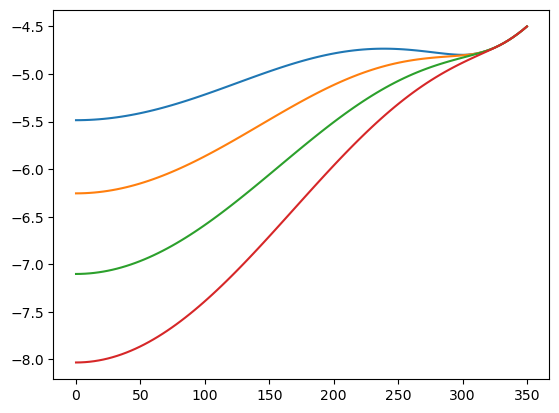

In [7]:
ϕ_lin = np.linspace(1e-5,350,100)
Ω_list = [Ω_tot(ϕi,0,300)/fπ**4 for ϕi in ϕ_lin]
plt.plot(ϕ_lin, Ω_list)
Ω_list = [Ω_tot(ϕi,0,310)/fπ**4 for ϕi in ϕ_lin]
plt.plot(ϕ_lin, Ω_list)
Ω_list = [Ω_tot(ϕi,0,320)/fπ**4 for ϕi in ϕ_lin]
plt.plot(ϕ_lin, Ω_list)
Ω_list = [Ω_tot(ϕi,0,330)/fπ**4 for ϕi in ϕ_lin]
plt.plot(ϕ_lin, Ω_list)
plt.show()

In [8]:
def P_and_ϵ_list_maker(μ_lin, mΔ, λΔ, gΔ, λ3):
    def Ωϕ(ϕ):
        if ϕ == 0:
            return 0 
        else: 
            return  h0*fπ*ϕ/mq - 1/2*m0**2*fπ**2*ϕ**2/(mq**2) + 1/24*λ0*fπ**4*ϕ**4/(mq**4) + 2*mq**4/((4*np.pi)**2)*(np.log(mq**2/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4) + 2*Nc*mq**4/((4*np.pi)**2)*(3/2)*ϕ**4/(mq**4)

    def ΩϕΔ(ϕ, Δ, μ, μe, μ8):
        if ϕ == 0 and Δ == 0:
            return 0
        if ϕ == 0:
            μ_bar = μ - μe/6 + μ8/3 
            return  (mΔ**2-4*μ_bar**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ+mπ**2*dCπ))*μ_bar**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ + mπ**2*dCπ))*(Δ**4)
        if Δ ==0:
            μ_bar = μ - μe/6 + μ8/3 
            return     4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)
        else:
            μ_bar = μ - μe/6 + μ8/3 
            return 1/12*λ3*fπ**2/(gΔ**2*mq**2)*Δ**2*ϕ**2 + 12/((4*np.pi)**2)*ϕ**2*Δ**2 + (mΔ**2-4*μ_bar**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ+mπ**2*dCπ))*μ_bar**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*(Δ**4) +  8/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*Δ**2*ϕ**2 + 4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2+Δ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)

    def Ωμ_original(ϕ, Δ, μ):
        if Δ != 0:
            def integrand(p):
                return p**2*(μ-E(p, ϕ))

            integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
            return -4*integral/(2*np.pi**2)

        else:
            def integrand(p):
                return p**2*(μ-E(p, ϕ))

            integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
            return -4*Nc*integral/(2*np.pi**2)

    def Ω1(ϕΔ,μ):
        ϕ, Δ = ϕΔ
        return Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ, 0, 0) - Ω_num(ϕ, Δ, μ)
    
    def Ω_tot(ϕΔ, μ):
        ϕ, Δ = ϕΔ
        return Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ, 0, 0) + Ωμ_original(ϕ, Δ, μ) - Ω_num(ϕ, Δ, μ)
    
    def Pressure(ϕ, Δ, μ):
        ϕΔ = [ϕ, Δ]
        return -Ω_tot(ϕΔ, μ)

    def EnergyDensity(ϕ, Δ, μ):
        ϕΔ = [ϕ, Δ]
        if Δ != 0:
            def integrand1(p):
                return p**2*((E(p, ϕ) + μ)/EΔp(p, ϕ, Δ, μ) - (E(p, ϕ) - μ)/EΔm(p, ϕ, Δ, μ) - 2*μ*Δ**2/(E(p,ϕ)**2+Δ**2)**(3/2))
            
            integral1, err1 = integrate.quad(integrand1, 0,  Λ_cutoff)
            
            def integrand2(p):
                return p**2
            
            integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
            
            def integrand3(p):
                return p**2*np.sqrt(p**2 + ϕ**2)
            
            integral3, err3 = integrate.quad(integrand3, 0,  np.sqrt(μ**2 - ϕ**2))
            
            return Ω1(ϕΔ,μ) + 8/gΔ**2*μ**2*Δ**2 + 32/(4*np.pi)**2*(np.log(mq**2/(ϕ**2 + Δ**2))-(Cπ+mπ**2*dCπ))*μ**2*Δ**2 + 4*μ*integral1/(2*np.pi**2) + 4*integral3/(2*np.pi**2)
    
        else:
            def integrand1(p):
                return p**2
            
            integral1, err1 = integrate.quad(integrand1, 0,  np.sqrt(μ**2 - ϕ**2))
            
            def integrand2(p):
                return p**2*np.sqrt(p**2 + ϕ**2)
            
            integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
            
            return Ω1(ϕΔ, μ) + 4*Nc*integral2/(2*np.pi**2)
        
    def number_density(ϕ, Δ, μ):
        if Δ != 0:
            def integrand1(p):
                return p**2*((E(p, ϕ) + μ)/EΔp(p, ϕ, Δ, μ) - (E(p, ϕ) - μ)/EΔm(p, ϕ, Δ, μ) - 2*μ*Δ**2/(E(p,ϕ)**2+Δ**2)**(3/2))
            
            integral1, err1 = integrate.quad(integrand1, 0,  Λ_cutoff)
            
            def integrand2(p):
                return p**2
            
            integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
            
            if ϕ == 0 and Δ == 0:
                return 0
            else:
                return 8/gΔ**2*μ*Δ**2 + 32/(4*np.pi)**2*np.log(mq**2/(ϕ**2 + Δ**2))*μ*Δ**2 + 4*integral1/(2*np.pi**2) + 4*integral2/(2*np.pi**2)
        else:
            
            def integrand1(p):
                return p**2
            
            integral1, err1 = integrate.quad(integrand1, 0, np.sqrt(μ**2-ϕ**2))
            
            return 4*Nc*integral1/(2*np.pi**2)
    
    P_list = []
    ϵ_list = []
    n_list = []
    Bag_const = -Ω_tot([300, 0], 0)
    
    def finding_minima(μ):
        init_guess = [150, 500]
        result = optimize.minimize(Ω_tot, init_guess, args=μ, method='Nelder-Mead', bounds=((0,300),(0,1500)))
        minima = result.x
        minima = np.append(minima, μ)
        #print(minima)
        return minima
    
    minima_list = [finding_minima(μi) for μi in tqdm(μ_lin)]
    P_list = [Pressure(i[0], i[1], i[2]) - Bag_const for i in minima_list]
    ϵ_list = [EnergyDensity(i[0], i[1], i[2]) + Bag_const for i in minima_list]
    n_list = [number_density(i[0], i[1], i[2]) for i in minima_list]
    return P_list, ϵ_list, n_list, minima_list

In [9]:
μ_lin = np.linspace(100, 700, 50)
P_list1, ϵ_list1, n_list1, min_list1 = P_and_ϵ_list_maker(μ_lin, 10000, λ0/4, 3/2*g0, λ0)

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:33: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:26: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
100%|██████████| 50/50 [00:00<00:00, 63.74it/s]
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:72: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integrand1, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:77: RuntimeWarning: invalid value encountered in sqrt
  integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:102: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integrand

In [10]:
min_ϕ_list1 = [i[0] for i in min_list1]
min_Δ_list1 = [i[1] for i in min_list1]
min_μ_list1 = [i[2] for i in min_list1]

n_list1_dim = np.array(n_list1)*MeV**3/(ħ*c)**3*fm**3 # Now in units fm^-3
P_list1_dim = np.array(P_list1)/197**3/1000 # Now in units GeV/fm^-3
ϵ_list1_dim = np.array(ϵ_list1)/197**3/1000 # Now in units GeV/fm^-3 

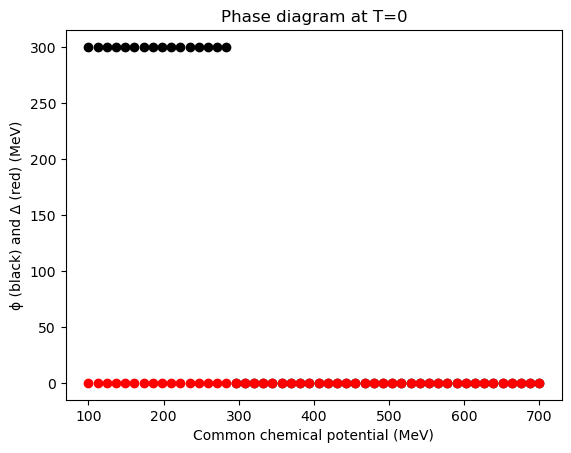

In [11]:
plt.title("Phase diagram at T=0")
plt.scatter(min_μ_list1, min_ϕ_list1, c="black")
plt.scatter(min_μ_list1, min_Δ_list1, c="red")
plt.xlabel("Common chemical potential (MeV)")
plt.ylabel("ϕ (black) and Δ (red) (MeV)")
plt.show()

In [12]:
print(min_ϕ_list1, min_Δ_list1)

[300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


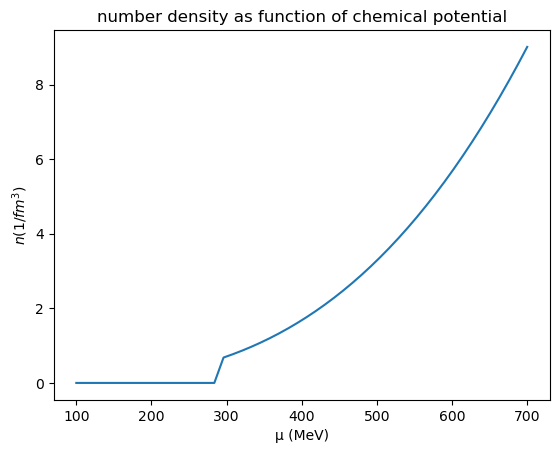

In [13]:
plt.title("number density as function of chemical potential")
plt.xlabel("μ (MeV)")
plt.ylabel(r"$n (1/fm^3)$")
plt.plot(min_μ_list1, n_list1_dim)
plt.show()

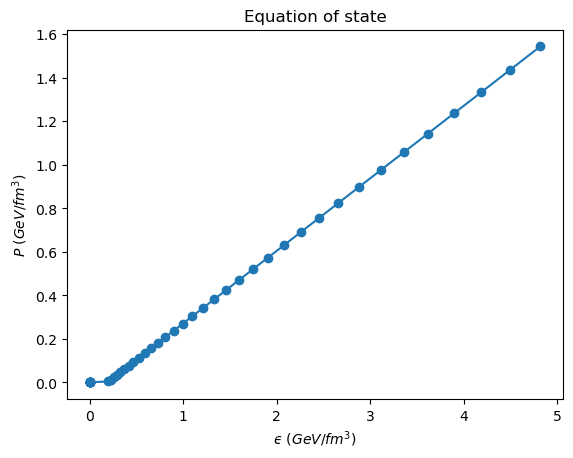

In [14]:
#plt.xlim(0, 0.05)
plt.title("Equation of state")
plt.ylabel(r"$P$" + " " + r"$(GeV/fm^3)$")
plt.xlabel(r"$ϵ$" + " " + r"$(GeV/fm^3)$")
plt.plot(ϵ_list1_dim, P_list1_dim)
plt.scatter(ϵ_list1_dim, P_list1_dim)
plt.show()

In [15]:
speed_of_sound_list1 = np.diff(P_list1_dim)/np.diff(ϵ_list1_dim)
n_list1_dim_plot = np.delete(n_list1_dim, 0)/n_sat
min_μ_list1_plot = np.delete(min_μ_list1, 0)
print(speed_of_sound_list1)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.01934283 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333]


C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\534834382.py:1: RuntimeWarning: invalid value encountered in divide
  speed_of_sound_list1 = np.diff(P_list1_dim)/np.diff(ϵ_list1_dim)


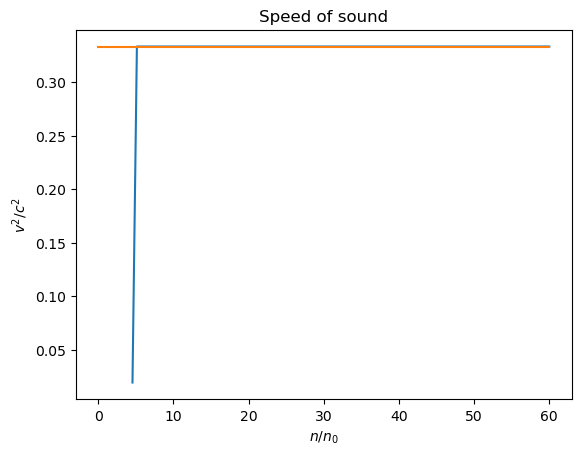

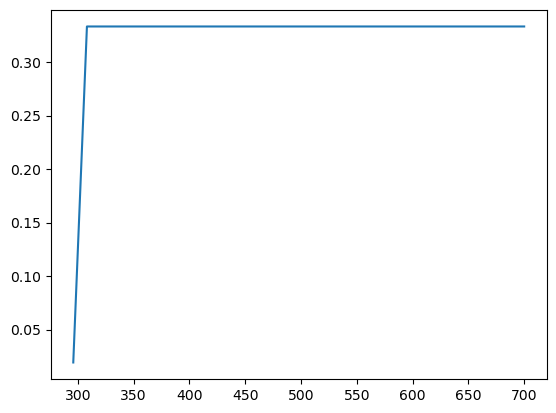

In [16]:
plt.title("Speed of sound")
plt.xlabel(r"$n/n_0$")
plt.ylabel(r"$v^2/c^2$")
plt.plot(n_list1_dim_plot, speed_of_sound_list1)
plt.plot(n_list1_dim_plot,[1/3]*len(n_list1_dim_plot))
plt.show()
plt.plot(min_μ_list1_plot, speed_of_sound_list1)
plt.show()

In [17]:
def Prefapring_for_plot_PT(μ_lin, mΔ, λΔ, gΔ, λ3):
    P_list, ϵ_list, n_list, min_list = P_and_ϵ_list_maker(μ_lin, mΔ, λΔ, gΔ, λ3)
    min_ϕ_list = [i[0] for i in min_list]
    min_Δ_list = [i[1] for i in min_list]
    
    return min_ϕ_list,  min_Δ_list

In [18]:
μ_lin = np.linspace(225, 340, 150)

min_ϕ_list1,  min_Δ_list1 = Prefapring_for_plot_PT(μ_lin, 500, λ0/4, 2*g0, λ0)
min_ϕ_list2,  min_Δ_list2 = Prefapring_for_plot_PT(μ_lin, 500, λ0/4, 3/2*g0, λ0)
min_ϕ_list3,  min_Δ_list3 = Prefapring_for_plot_PT(μ_lin, 600, λ0/4, 2*g0, λ0)
min_ϕ_list4,  min_Δ_list4 = Prefapring_for_plot_PT(μ_lin, 600, λ0/4, 3/2*g0, λ0)

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:33: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
  0%|          | 0/150 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:26: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
100%|██████████| 150/150 [00:37<00:00,  4.00it/s]
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:72: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integrand1, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:77: RuntimeWarning: invalid value encountered in sqrt
  integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:102: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integr

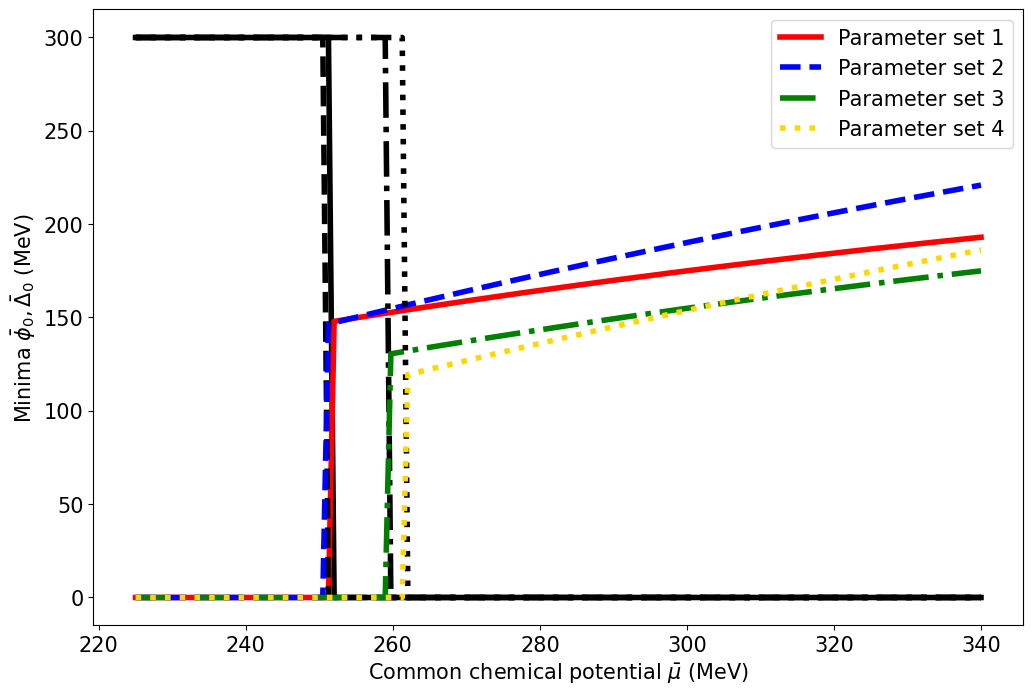

In [19]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))

plt.xlabel('Common chemical potential ' + r"$\bar{\mu}$" +  ' (MeV)')
plt.ylabel('Minima ' + r"$\bar{\phi}_0, \bar{\Delta}_0$" + " (MeV)")
plt.plot(μ_lin, min_ϕ_list1, c="black", linewidth=4)
plt.plot(μ_lin, min_Δ_list1, c="red", linewidth=4, label="Parameter set 1")

plt.plot(μ_lin, min_ϕ_list2, linestyle = 'dashed', c="black", linewidth=4)
plt.plot(μ_lin, min_Δ_list2, linestyle = 'dashed', c="blue", linewidth=4, label="Parameter set 2")

plt.plot(μ_lin, min_ϕ_list3, linestyle = 'dashdot', c="black", linewidth=4)
plt.plot(μ_lin, min_Δ_list3, linestyle = 'dashdot', c="green", linewidth=4, label="Parameter set 3")

plt.plot(μ_lin, min_ϕ_list4, linestyle = 'dotted', c="black", linewidth=4)
plt.plot(μ_lin, min_Δ_list4, linestyle = 'dotted', c="gold", linewidth=4, label="Parameter set 4")
plt.legend(loc="upper right")
plt.savefig("PhaseTransitionT0_new.pdf")
plt.show()

In [20]:
def Preparing_for_plot_SoS(μ_lin, mΔ, λΔ, gΔ, λ3):
    P_list, ϵ_list, n_list, min_list = P_and_ϵ_list_maker(μ_lin, mΔ, λΔ, gΔ, λ3)
    
    
    min_ϕ_list = [i[0] for i in min_list]
    min_Δ_list = [i[1] for i in min_list]
    min_μ_list = [i[2] for i in min_list]
    
    plt.title("Phase diagram at T=0")
    plt.plot(min_μ_list, min_ϕ_list, c="black")
    plt.plot(min_μ_list, min_Δ_list, c="red")
    plt.xlabel("Common chemical potential (MeV)")
    plt.ylabel("ϕ (black) and Δ (red) (MeV)")
    plt.show()
    
    n_list_dim = np.array(n_list)*MeV**3/(ħ*c)**3*fm**3 # Now in units fm^-3
    P_list_dim = np.array(P_list)/197**3/1000 # Now in units GeV/fm^-3
    ϵ_list_dim = np.array(ϵ_list)/197**3/1000 # Now in units GeV/fm^-3 
    v_list = np.diff(P_list_dim)/np.diff(ϵ_list_dim) #v^2/c^2
    n_list_dim_plot = np.delete(n_list_dim, 0)/n_sat
    trace_anomaly_list = [1/3]*len(P_list_dim) - P_list_dim/ϵ_list_dim
    print(trace_anomaly_list)
    
    plt.title("Number density as function of chemical potential")
    plt.plot(μ_lin, n_list_dim)
    plt.xlabel("Common chemical potential μ (MeV)")
    plt.ylabel("Number density n " + r"$fm^{-3}$")
    plt.show()
    return v_list, n_list_dim_plot, trace_anomaly_list

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:33: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:26: RuntimeWarning: invalid value encountered in sqrt
  integral, err = integrate.quad(integrand, 0, np.sqrt(μ**2 - ϕ**2))
100%|██████████| 100/100 [00:25<00:00,  3.94it/s]
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:72: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integrand1, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:77: RuntimeWarning: invalid value encountered in sqrt
  integral2, err2 = integrate.quad(integrand2, 0,  np.sqrt(μ**2 - ϕ**2))
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\170788889.py:102: RuntimeWarning: invalid value encountered in sqrt
  integral1, err1 = integrate.quad(integr

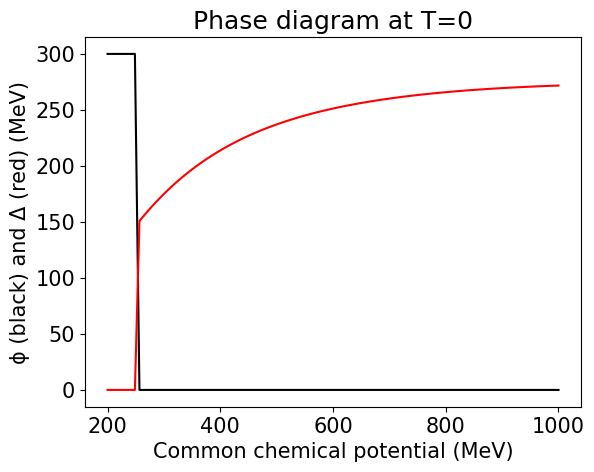

[        nan         nan         nan         nan         nan         nan
         nan  0.3090053   0.2800882   0.25357429  0.2292647   0.20697335
  0.18652783  0.16776988  0.15055483  0.13475045  0.12023666  0.10690428
  0.09465419  0.08339644  0.07304907  0.06353757  0.05479415  0.04675718
  0.03936993  0.03258111  0.02634362  0.02061408  0.01535289  0.01052376
  0.0060933   0.00203088 -0.00169182 -0.00510083 -0.0082201  -0.01107169
 -0.0136761  -0.016052   -0.01821684 -0.02018669 -0.02197631 -0.0235994
 -0.02506864 -0.02639578 -0.02759155 -0.02866605 -0.02962848 -0.03048744
 -0.03125091 -0.03192615 -0.03252    -0.03303875 -0.03348819 -0.03387373
 -0.03420038 -0.03447274 -0.03469509 -0.03487143 -0.03500538 -0.03510036
 -0.03515954 -0.03518583 -0.03518192 -0.03515033 -0.03509337 -0.03501318
 -0.03491179 -0.03479099 -0.03465253 -0.03449798 -0.0343288  -0.03414636
 -0.03395191 -0.0337466  -0.03353153 -0.03330769 -0.033076   -0.03283732
 -0.03259244 -0.03234208 -0.03208693 -0.03182761 -0.

C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\468226842.py:19: RuntimeWarning: invalid value encountered in divide
  v_list = np.diff(P_list_dim)/np.diff(ϵ_list_dim) #v^2/c^2
C:\Users\mathi\AppData\Local\Temp\ipykernel_27864\468226842.py:21: RuntimeWarning: invalid value encountered in divide
  trace_anomaly_list = [1/3]*len(P_list_dim) - P_list_dim/ϵ_list_dim


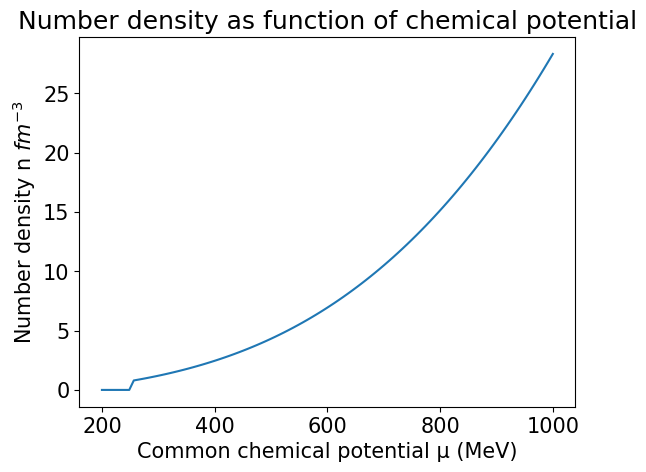

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


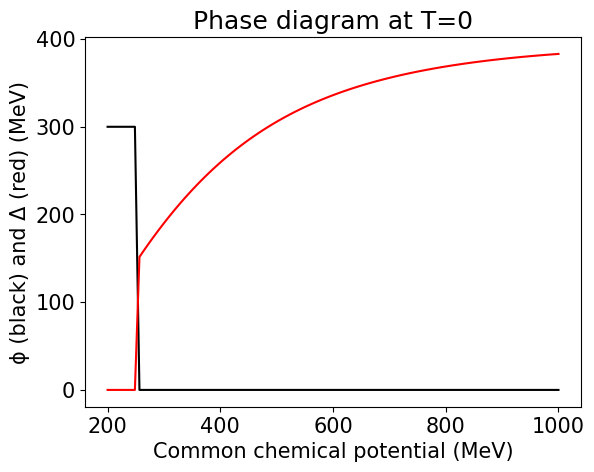

[        nan         nan         nan         nan         nan         nan
         nan  0.30991968  0.28144707  0.25562875  0.23216343  0.21078308
  0.19125206  0.17336345  0.15693751  0.1418168   0.12786492  0.11496249
  0.10300647  0.09190594  0.08158182  0.07196531  0.06299498  0.05461765
  0.046786    0.03945788  0.03259594  0.02616682  0.02014075  0.01449069
  0.00919201  0.00422279 -0.00043724 -0.00480652 -0.00890215 -0.01273967
 -0.01633383 -0.01969803 -0.02284487 -0.02578628 -0.02853335 -0.03109624
 -0.033485   -0.03570885 -0.03777646 -0.0396962  -0.04147595 -0.04312314
 -0.04464488 -0.04604788 -0.04733858 -0.04852303 -0.04960707 -0.0505962
 -0.05149569 -0.05231046 -0.05304535 -0.05370484 -0.05429324 -0.05481458
 -0.05527279 -0.05567155 -0.05601438 -0.05630457 -0.05654532 -0.05673959
 -0.05689023 -0.05699995 -0.05707131 -0.0571067  -0.05710844 -0.0570787
 -0.05701955 -0.05693289 -0.05682059 -0.05668439 -0.05652593 -0.05634678
 -0.05614837 -0.05593213 -0.05569936 -0.05545127 -0.0

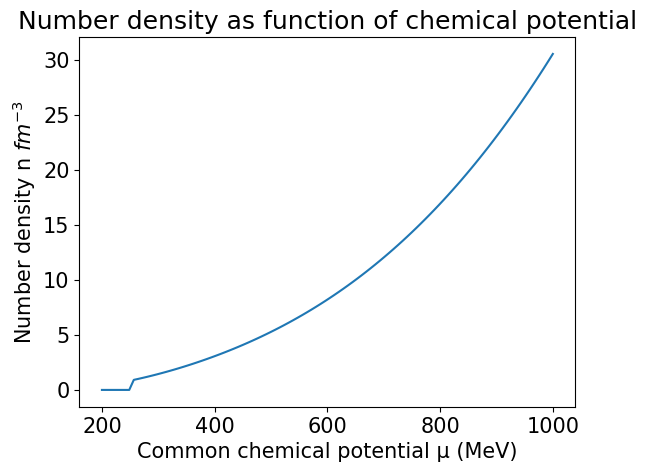

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


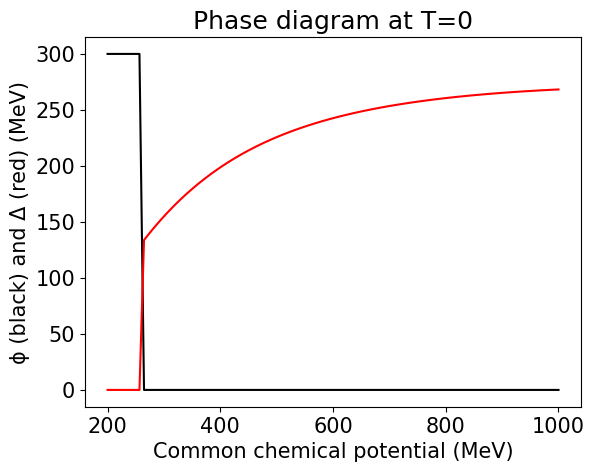

[        nan         nan         nan         nan         nan         nan
         nan         nan  0.31209676  0.28405155  0.25838886  0.23489456
  0.21337144  0.19363941  0.175535    0.15891058  0.1436331   0.12958276
  0.11665186  0.10474348  0.09377046  0.08365399  0.07432322  0.06571384
  0.0577679   0.05043248  0.04365949  0.03740536  0.03163011  0.02629721
  0.02137346  0.01682799  0.01263288  0.00876206  0.00519187  0.00190022
 -0.00113298 -0.00392668 -0.006498   -0.008863   -0.01103654 -0.01303225
 -0.01486295 -0.01654039 -0.01807549 -0.01947845 -0.02075867 -0.02192488
 -0.02298521 -0.02394727 -0.02481803 -0.02560403 -0.02631136 -0.02694564
 -0.02751213 -0.02801567 -0.02846086 -0.02885186 -0.02919266 -0.02948691
 -0.02973798 -0.02994907 -0.03012311 -0.03026286 -0.03037087 -0.03044952
 -0.03050103 -0.03052746 -0.03053072 -0.03051262 -0.03047482 -0.03041886
 -0.0303462  -0.03025818 -0.03015605 -0.03004098 -0.02991405 -0.02977629
 -0.02962862 -0.02947191 -0.02930701 -0.02913466 -0

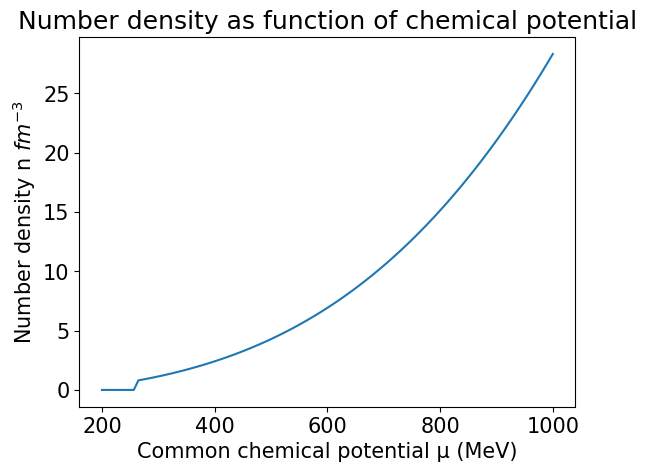

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


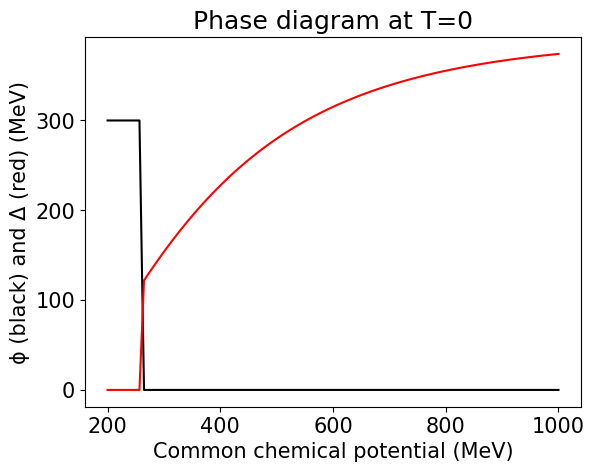

[            nan             nan             nan             nan
             nan             nan             nan             nan
  3.28151682e-01  2.99507335e-01  2.73646231e-01  2.50241000e-01
  2.28999158e-01  2.09663074e-01  1.92007576e-01  1.75836897e-01
  1.60981751e-01  1.47294992e-01  1.34650146e-01  1.22937574e-01
  1.12062160e-01  1.01941371e-01  9.25035651e-02  8.36862807e-02
  7.54351100e-02  6.77016221e-02  6.04444212e-02  5.36256317e-02
  4.72128846e-02  4.11763387e-02  3.54902459e-02  3.01311286e-02
  2.50778414e-02  2.03110332e-02  1.58137129e-02  1.15699975e-02
  7.56531408e-03  3.78663088e-03  2.21599719e-04 -3.14117475e-03
 -6.31224646e-03 -9.30145022e-03 -1.21178017e-02 -1.47701853e-02
 -1.72666528e-02 -1.96147140e-02 -2.18217433e-02 -2.38946423e-02
 -2.58398016e-02 -2.76634983e-02 -2.93715423e-02 -3.09695948e-02
 -3.24629668e-02 -3.38567103e-02 -3.51557401e-02 -3.63647409e-02
 -3.74880009e-02 -3.85298685e-02 -3.94943991e-02 -4.03854048e-02
 -4.12066390e-02 -4.19615

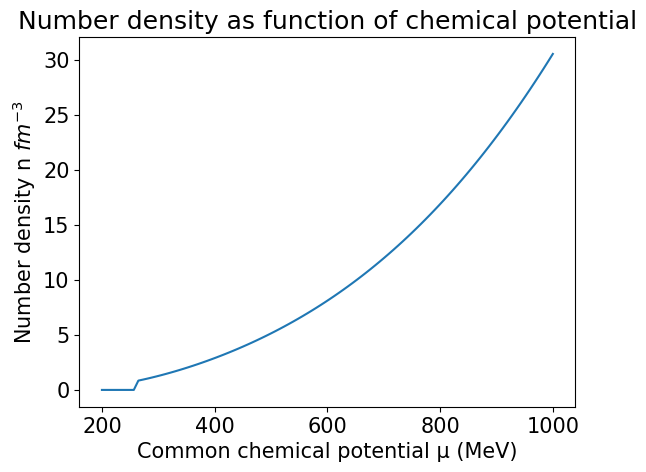

In [21]:
#plt.rcParams.update({'font.size': 15})
#fig = plt.figure(figsize=(12,8))
μ_lin = np.linspace(200, 1000, 100)
μ_lin_for_plot = np.delete(μ_lin, 0)

vc_list1, num_list1, trace_anomaly_list1 = Preparing_for_plot_SoS(μ_lin, 500, λ0/4, 2*g0, λ0)
vc_list2, num_list2, trace_anomaly_list2 = Preparing_for_plot_SoS(μ_lin, 500, λ0/4, 3/2*g0, λ0)
vc_list3, num_list3, trace_anomaly_list3 = Preparing_for_plot_SoS(μ_lin, 600, λ0/4, 2*g0, λ0)
vc_list4, num_list4, trace_anomaly_list4 = Preparing_for_plot_SoS(μ_lin, 600, λ0/4, 3/2*g0, λ0)

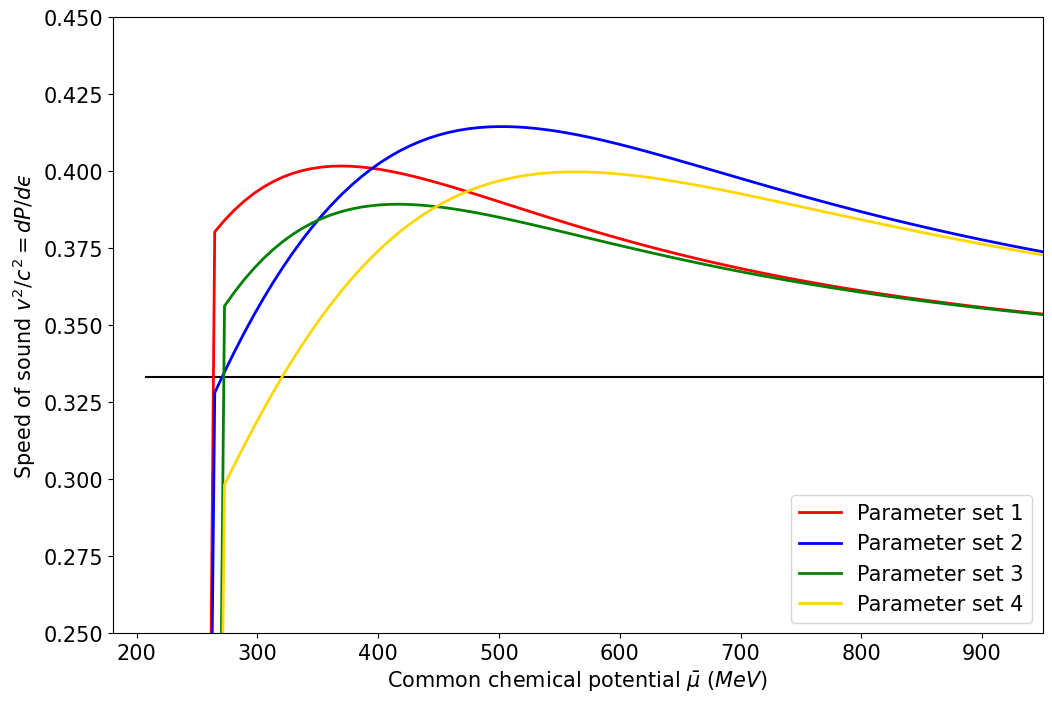

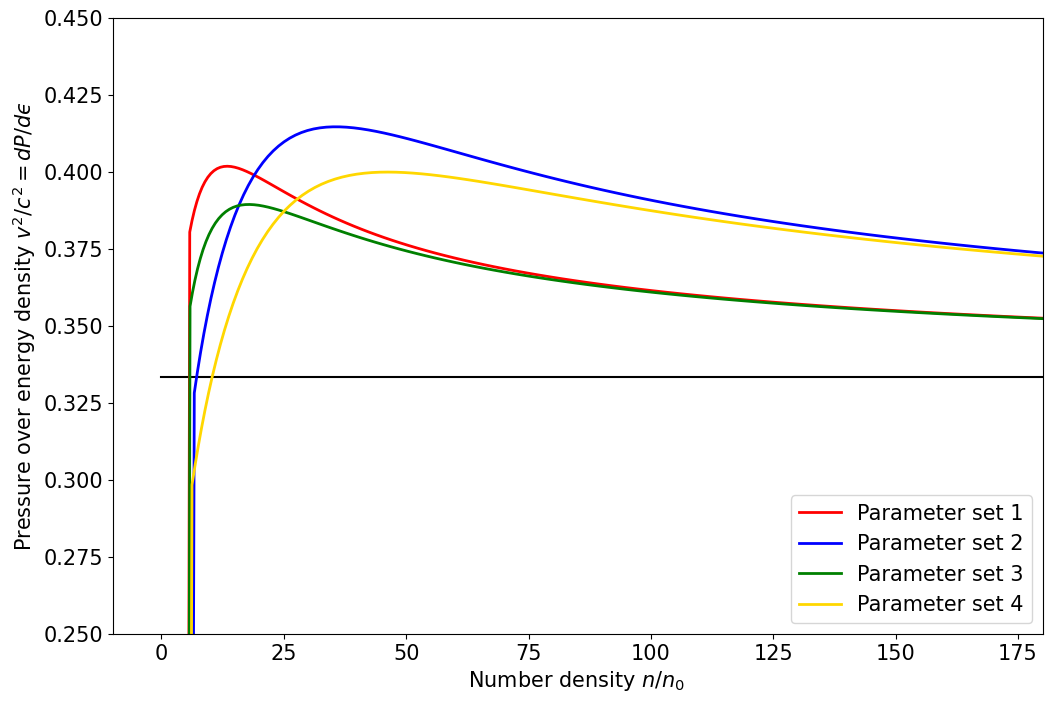

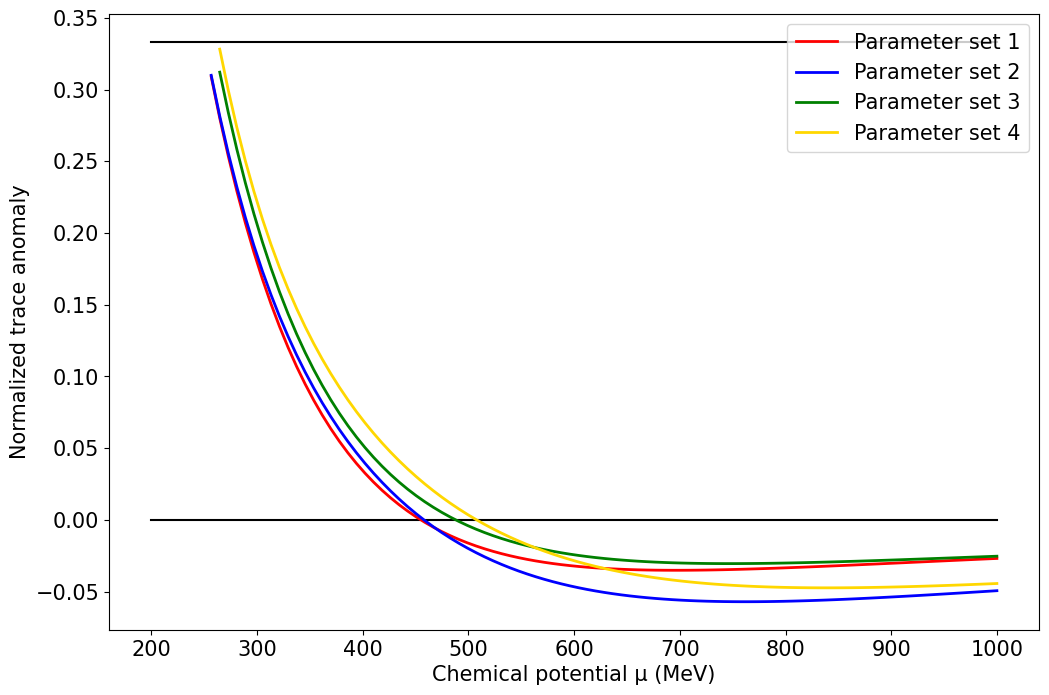

In [22]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))

plt.xlabel('Common chemical potential ' + r"$\bar{\mu}$" + " " +  r'$(MeV)$')
plt.ylabel('Speed of sound ' +r'$v^2/c^2 = dP/dϵ$')
plt.plot(μ_lin_for_plot, [1/3]*len(μ_lin_for_plot), c="black")
plt.plot(μ_lin_for_plot, vc_list1, c="red", linewidth=2, label="Parameter set 1")
plt.plot(μ_lin_for_plot, vc_list2, c="blue", linewidth=2, label="Parameter set 2")
plt.plot(μ_lin_for_plot, vc_list3, c="green", linewidth=2, label="Parameter set 3")
plt.plot(μ_lin_for_plot, vc_list4, c="gold", linewidth=2, label="Parameter set 4")
plt.ylim(0.25, 0.45)
plt.xlim(180, 950)
plt.legend(loc="lower right")
plt.savefig("cs_mu.pdf")
plt.show()


fig = plt.figure(figsize=(12,8))

plt.xlabel('Number density ' + r"$n/n_0$" + " ")
plt.ylabel('Pressure over energy density ' +r'$v^2/c^2 = dP/dϵ$')
plt.plot(num_list2, [1/3]*len(num_list2), c="black")
plt.plot(num_list1, vc_list1, c="red", linewidth=2, label="Parameter set 1")
plt.plot(num_list2, vc_list2, c="blue", linewidth=2, label="Parameter set 2")
plt.plot(num_list3, vc_list3, c="green", linewidth=2, label="Parameter set 3")
plt.plot(num_list4, vc_list4, c="gold", linewidth=2, label="Parameter set 4")
plt.ylim(0.25, 0.45)
plt.xlim(-10, 180)
plt.legend(loc="lower right")
plt.savefig("cs_n0.pdf")
plt.show()


fig = plt.figure(figsize=(12,8))

plt.ylabel("Normalized trace anomaly")
plt.xlabel('Chemical potential μ (MeV)')
plt.plot(μ_lin, [0]*len(μ_lin), c="black")
#plt.plot(μ_lin, [-2/3]*len(μ_lin), c="black")
plt.plot(μ_lin, [1/3]*len(μ_lin), c="black")
plt.plot(μ_lin, trace_anomaly_list1, c="red", linewidth=2, label="Parameter set 1")
plt.plot(μ_lin, trace_anomaly_list2, c="blue", linewidth=2, label="Parameter set 2")
plt.plot(μ_lin, trace_anomaly_list3, c="green", linewidth=2, label="Parameter set 3")
plt.plot(μ_lin, trace_anomaly_list4, c="gold", linewidth=2, label="Parameter set 4")
plt.legend(loc="upper right")
plt.savefig("trace_anomaly.pdf")
plt.show()